<a href="https://colab.research.google.com/github/RishitSingh10/GANs/blob/main/GAN_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GAN Trained on MNIST

## Imports

In [1]:
import numpy as np
import torch
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt

### Import utility functions

In [2]:
!wget https://raw.githubusercontent.com/rasbt/stat453-deep-learning-ss21/main/L18/helper_data.py
!wget https://raw.githubusercontent.com/rasbt/stat453-deep-learning-ss21/main/L18/helper_train.py
!wget https://raw.githubusercontent.com/rasbt/stat453-deep-learning-ss21/main/L18/helper_utils.py
!wget https://raw.githubusercontent.com/rasbt/stat453-deep-learning-ss21/main/L18/helper_plotting.py
!wget https://raw.githubusercontent.com/rasbt/stat453-deep-learning-ss21/main/L18/helper_evaluate.py

--2024-08-05 13:27:59--  https://raw.githubusercontent.com/rasbt/stat453-deep-learning-ss21/main/L18/helper_data.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9629 (9.4K) [text/plain]
Saving to: ‘helper_data.py’

helper_data.py      100%[===================>]   9.40K  --.-KB/s    in 0s      

2024-08-05 13:28:00 (86.5 MB/s) - ‘helper_data.py’ saved [9629/9629]

--2024-08-05 13:28:00--  https://raw.githubusercontent.com/rasbt/stat453-deep-learning-ss21/main/L18/helper_train.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23

In [3]:
from helper_data import get_dataloaders_mnist
from helper_train import train_gan_v1
from helper_utils import set_deterministic, set_all_seeds
from helper_plotting import plot_multiple_training_losses
from helper_plotting import plot_generated_images

In [4]:
!nvidia-smi

Mon Aug  5 13:28:01 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [18]:
## SETTINGS

# Device
DEVICE = torch.device('cuda:0')
print('Device:', DEVICE)

# Hyperparameters
RANDOM_SEED = 42
GENERATOR_LEARNING_RATE = 0.0002
DISCRIMINATOR_LEARNING_RATE = 0.0002

NUM_EPOCHS = 100
BATCH_SIZE = 128

IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS = 28, 28, 1

Device: cuda:0


## Dataset

In [19]:
from torchvision import datasets
from torch.utils.data import DataLoader

custom_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root = 'data',
                               train = True,
                               transform = custom_transforms,
                               download = True)

train_loader = DataLoader(dataset = train_dataset,
                          batch_size = BATCH_SIZE,
                          shuffle = True)

# Checking the dataset
for images, labels in train_loader:
  print('Image batch dimensions:', images.shape)
  print('Image label dimensions:', labels.shape)
  break

Image batch dimensions: torch.Size([128, 1, 28, 28])
Image label dimensions: torch.Size([128])


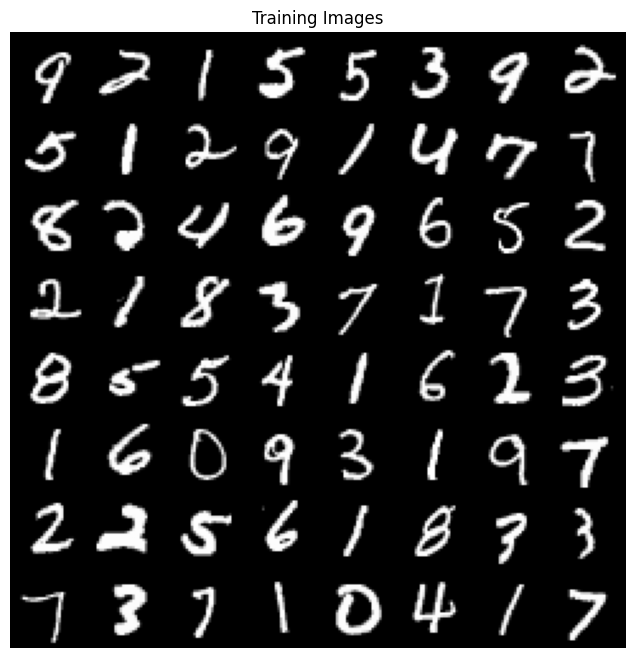

In [20]:
plt.figure(figsize = (8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(images[:64],
                                                    padding = 2, normalize = True),
                        (1, 2, 0)))
plt.show()

## Model

In [34]:
### MODEL

class GAN(torch.nn.Module):

  def __init__(self, latent_dim = 100,
               image_height = 28, image_width = 28, color_channels = 1):
    super().__init__()

    self.image_height = image_height
    self.image_width = image_width
    self.color_channels = color_channels

    self.generator = nn.Sequential(
        nn.Linear(latent_dim, 128),
        nn.LeakyReLU(inplace = True),
        nn.Dropout(p = 0.5),
        nn.Linear(128, image_height*image_width*color_channels),
        nn.Tanh()
    )

    self.discriminator = nn.Sequential(
        nn.Flatten(),
        nn.Linear(image_height*image_width*color_channels, 128),
        nn.LeakyReLU(inplace = True),
        nn.Dropout(p = 0.5),
        nn.Linear(128, 1)
    )

  def generator_forward(self, z): # z has dimension NCHW
    z = torch.flatten(z, start_dim = 1)
    img = self.generator(z)
    img = img.view(z.size(0),
                    self.color_channels,
                    self.image_height,
                    self.image_width)
    return img

  def discriminator_forward(self, img):
    img = img.to(DEVICE)
    logits = self.discriminator(img)
    return logits

In [35]:
set_all_seeds(RANDOM_SEED)

model = GAN()
model.to(DEVICE)

optim_gen = torch.optim.Adam(model.generator.parameters(),
                             betas=(0.5, 0.999),
                             lr = GENERATOR_LEARNING_RATE)

optim_discr = torch.optim.Adam(model.discriminator.parameters(),
                               betas = (0.5, 0.999),
                               lr = DISCRIMINATOR_LEARNING_RATE)

## Training

In [36]:
log_dict = train_gan_v1(num_epochs = NUM_EPOCHS,
                        model = model,
                        optimizer_gen = optim_gen,
                        optimizer_discr = optim_discr,
                        latent_dim = 100,
                        device = DEVICE,
                        train_loader = train_loader,
                        logging_interval = 100,
                        save_model = 'gan_mnist_01.pt')

Epoch: 001/100 | Batch 000/469 | Gen/Dis Loss: 0.7354/0.6944
Epoch: 001/100 | Batch 100/469 | Gen/Dis Loss: 0.5949/0.4952
Epoch: 001/100 | Batch 200/469 | Gen/Dis Loss: 0.6426/0.5506
Epoch: 001/100 | Batch 300/469 | Gen/Dis Loss: 0.7098/0.5435
Epoch: 001/100 | Batch 400/469 | Gen/Dis Loss: 0.8927/0.4622
Time elapsed: 0.24 min
Epoch: 002/100 | Batch 000/469 | Gen/Dis Loss: 0.9928/0.4115
Epoch: 002/100 | Batch 100/469 | Gen/Dis Loss: 1.0238/0.4132
Epoch: 002/100 | Batch 200/469 | Gen/Dis Loss: 1.0657/0.4213
Epoch: 002/100 | Batch 300/469 | Gen/Dis Loss: 1.0434/0.4230
Epoch: 002/100 | Batch 400/469 | Gen/Dis Loss: 1.0378/0.4390
Time elapsed: 0.48 min
Epoch: 003/100 | Batch 000/469 | Gen/Dis Loss: 1.0266/0.4535
Epoch: 003/100 | Batch 100/469 | Gen/Dis Loss: 0.9442/0.4678
Epoch: 003/100 | Batch 200/469 | Gen/Dis Loss: 1.0048/0.4310
Epoch: 003/100 | Batch 300/469 | Gen/Dis Loss: 1.1601/0.4197
Epoch: 003/100 | Batch 400/469 | Gen/Dis Loss: 0.9449/0.4893
Time elapsed: 0.72 min
Epoch: 004/100 |

## Evaluation

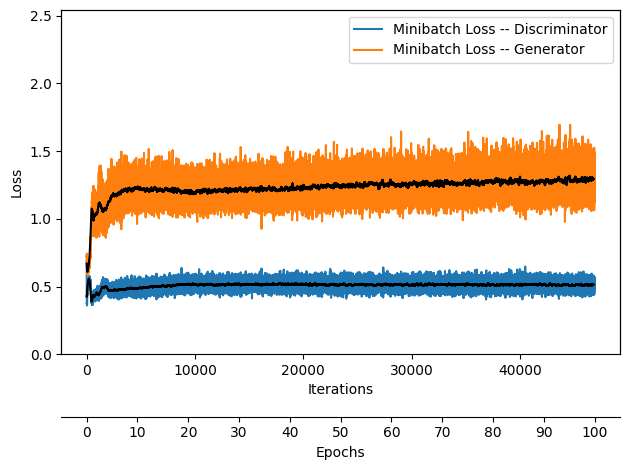

In [37]:
plot_multiple_training_losses(
    losses_list=(log_dict['train_discriminator_loss_per_batch'],
                 log_dict['train_generator_loss_per_batch']),
    num_epochs=NUM_EPOCHS,
    custom_labels_list=(' -- Discriminator', ' -- Generator')
)

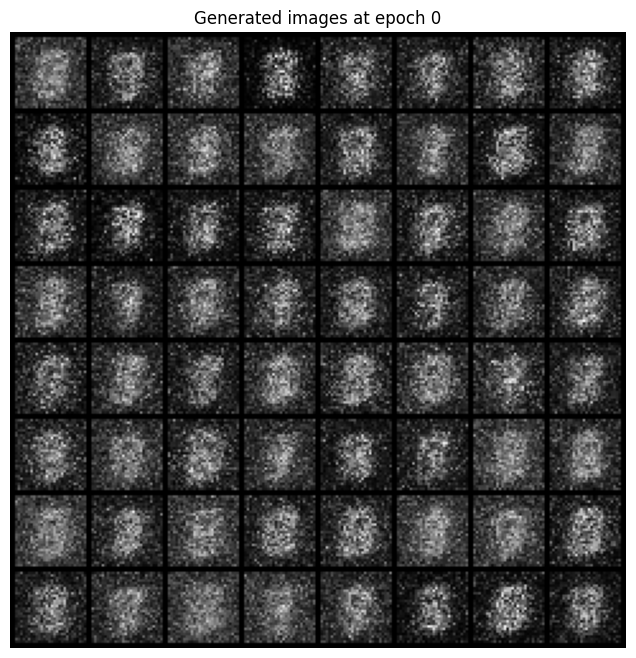

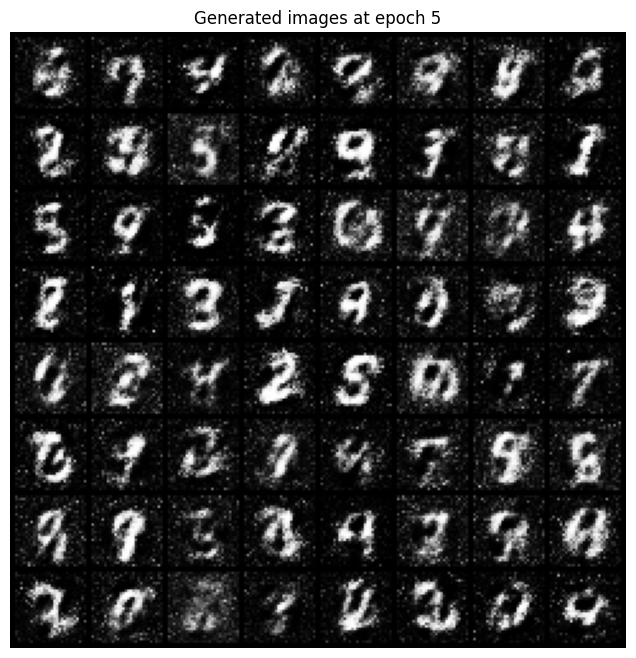

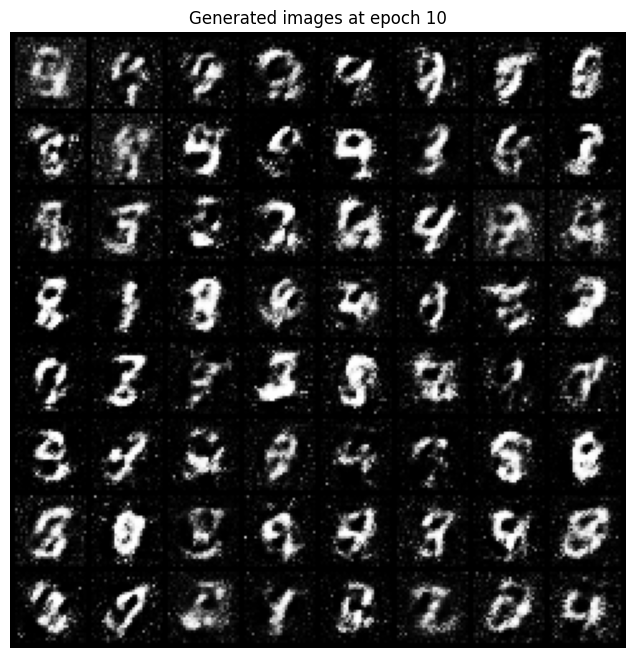

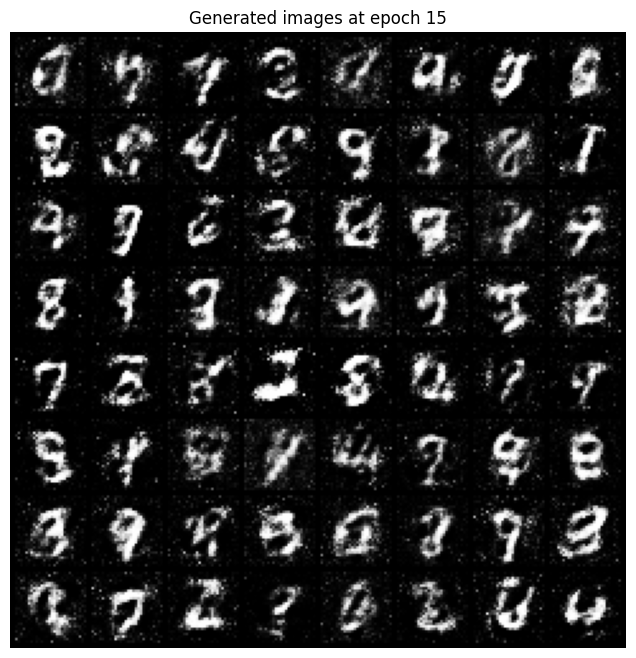

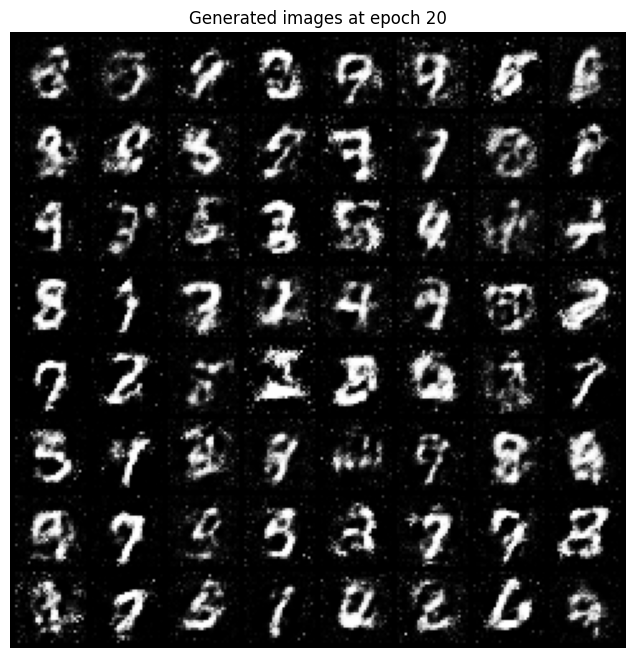

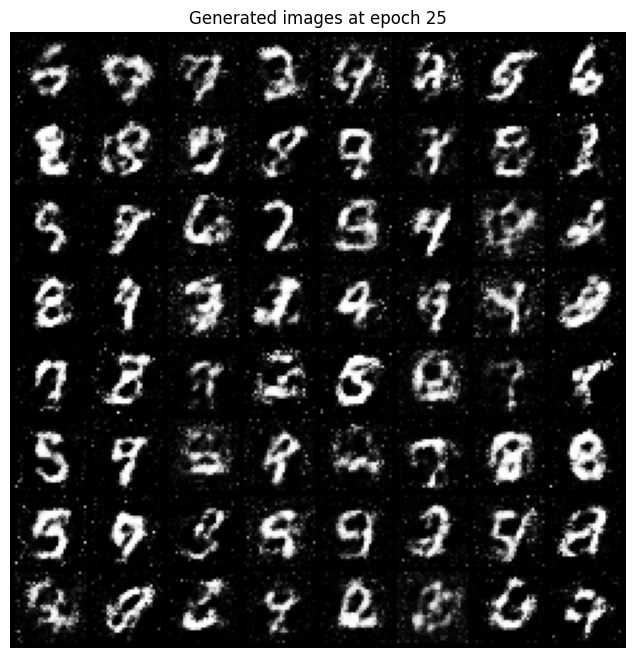

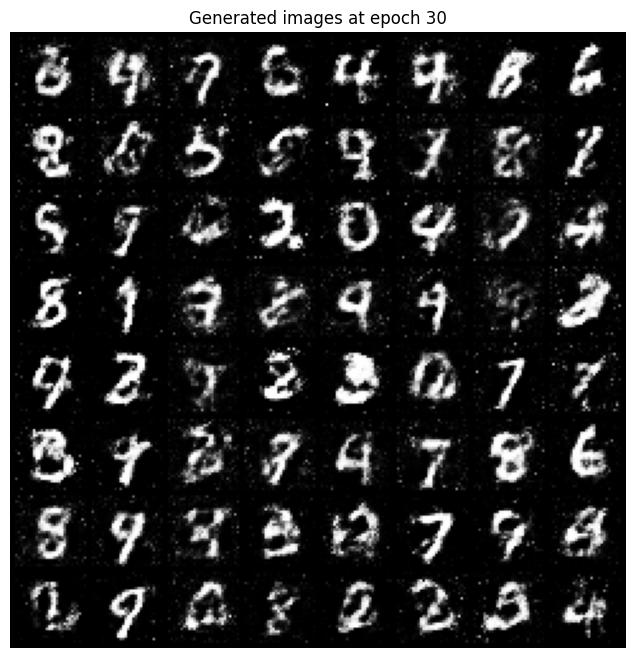

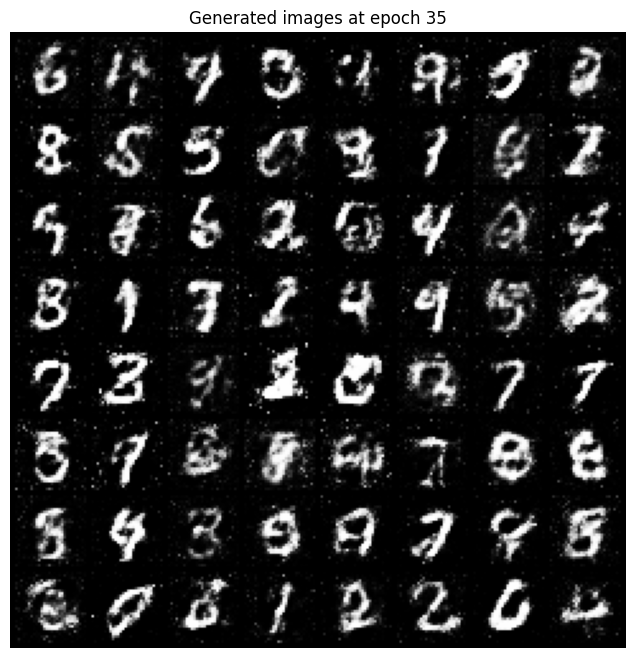

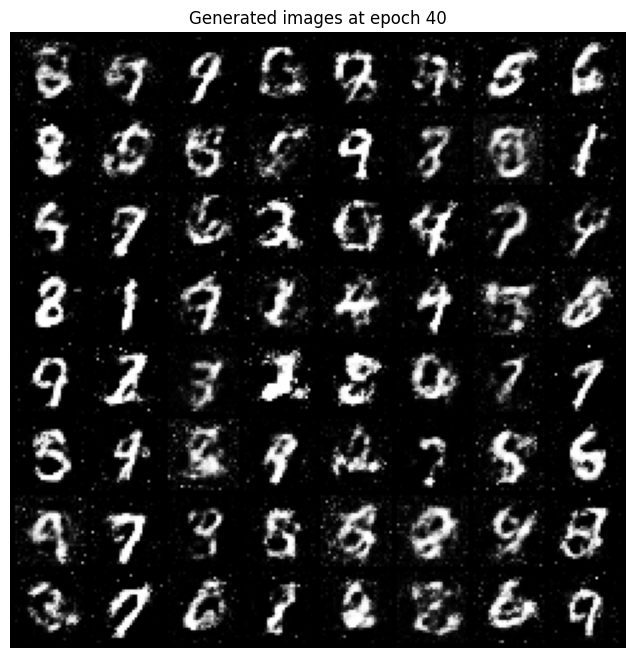

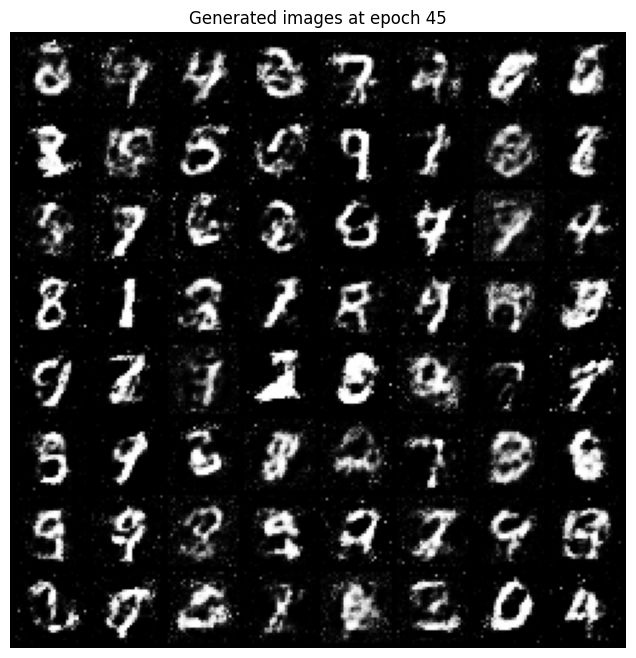

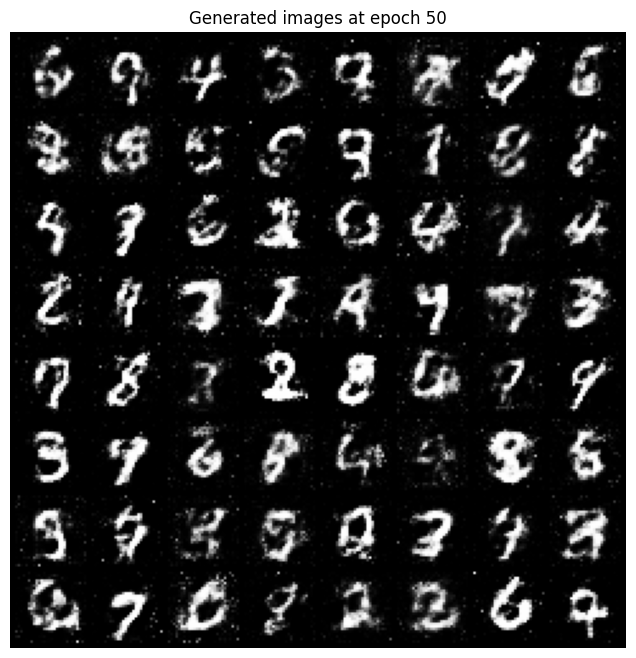

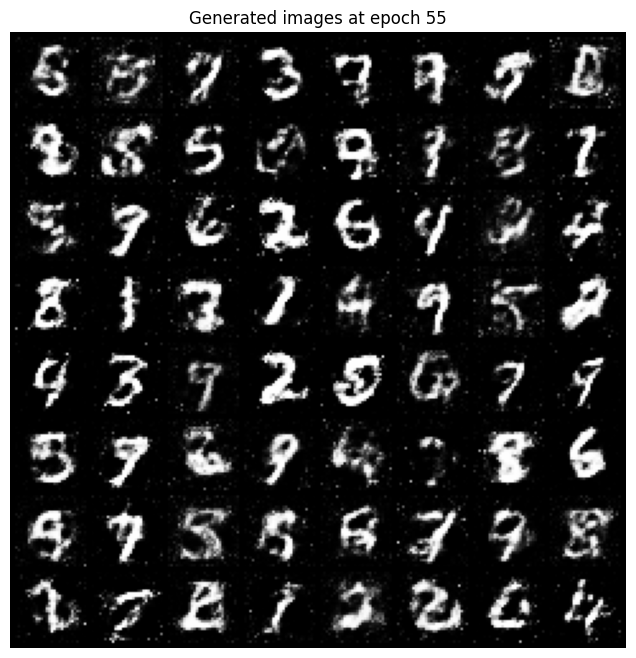

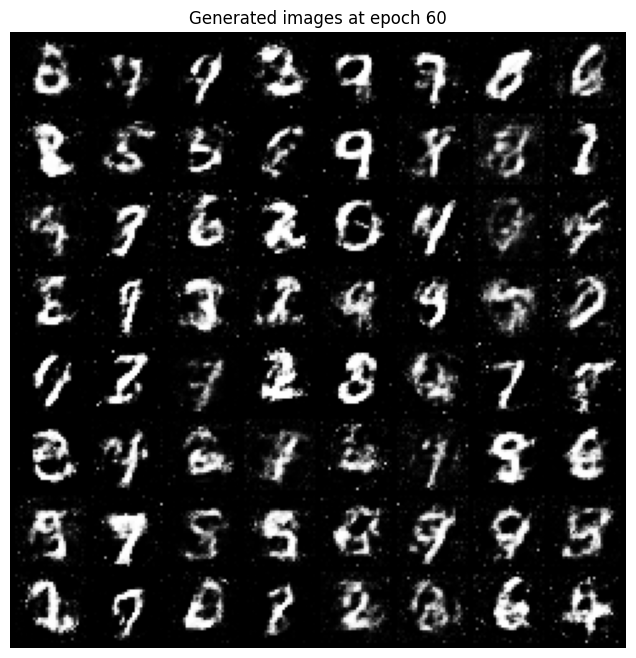

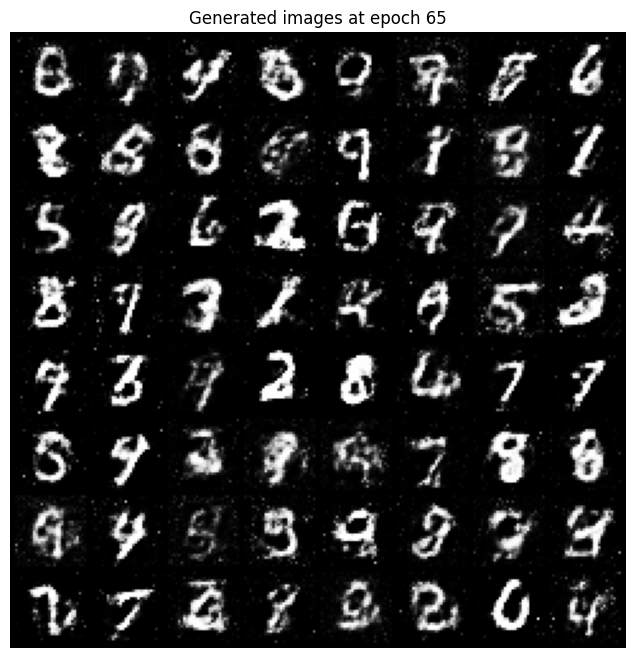

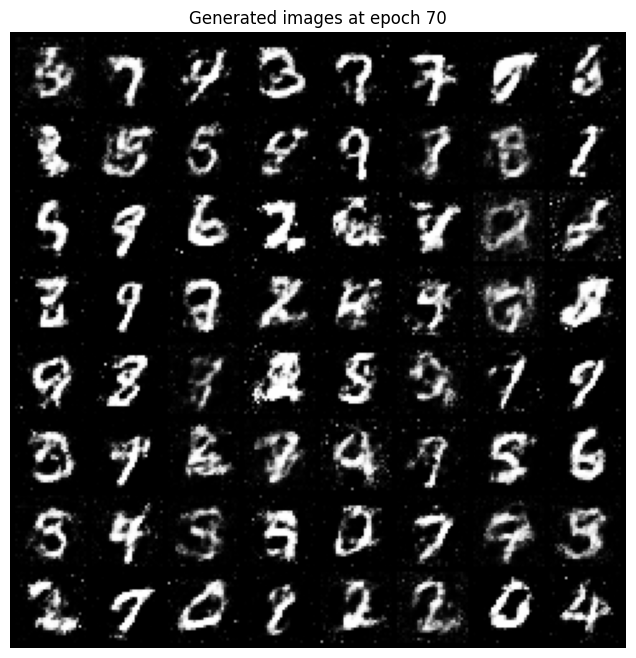

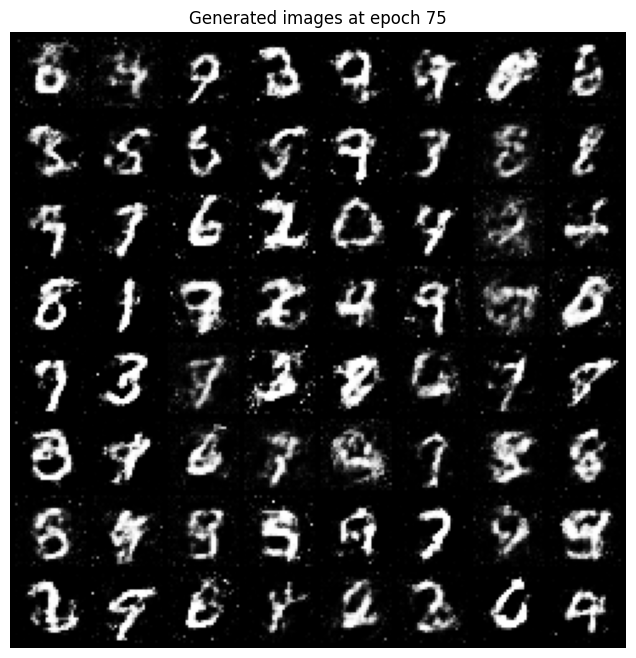

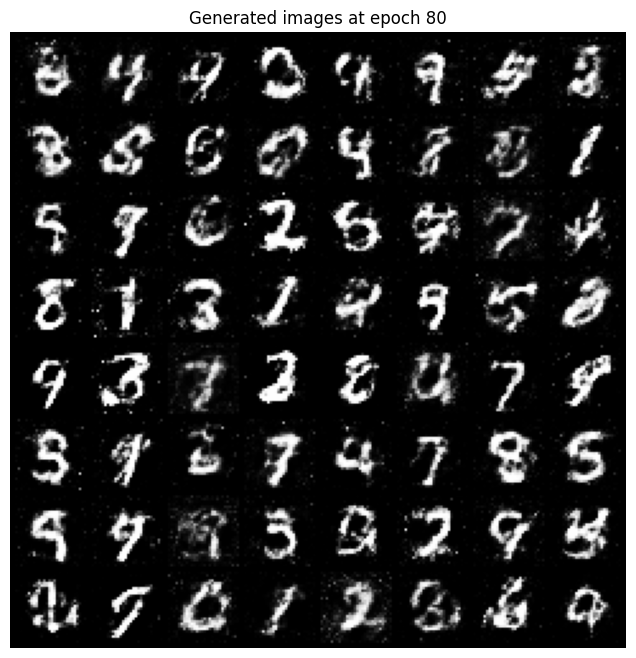

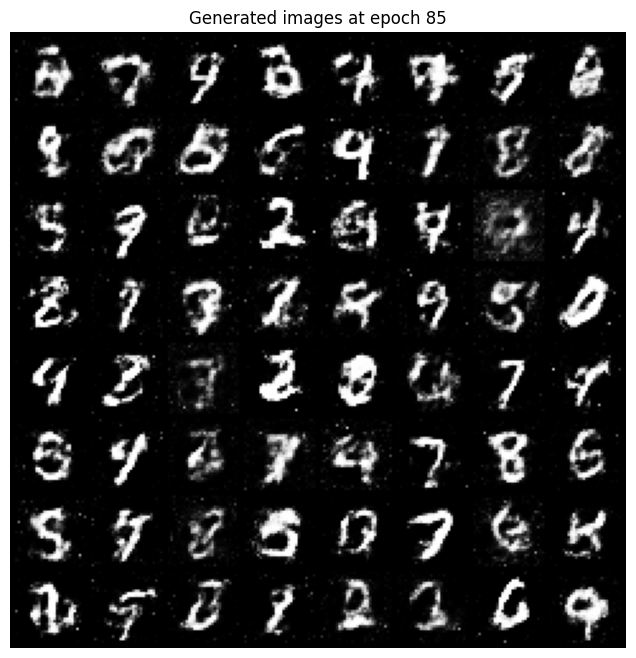

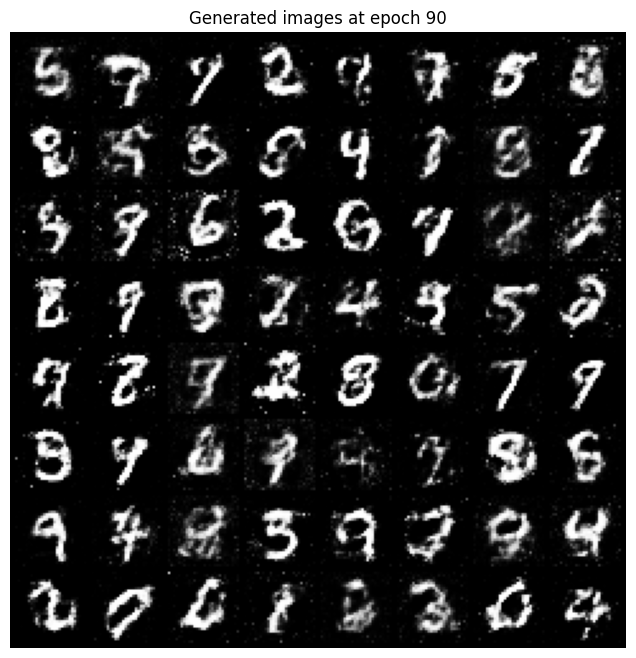

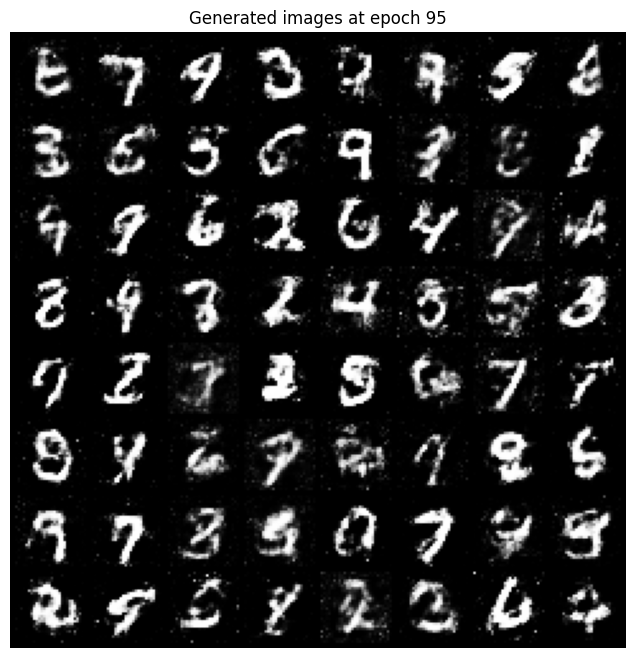

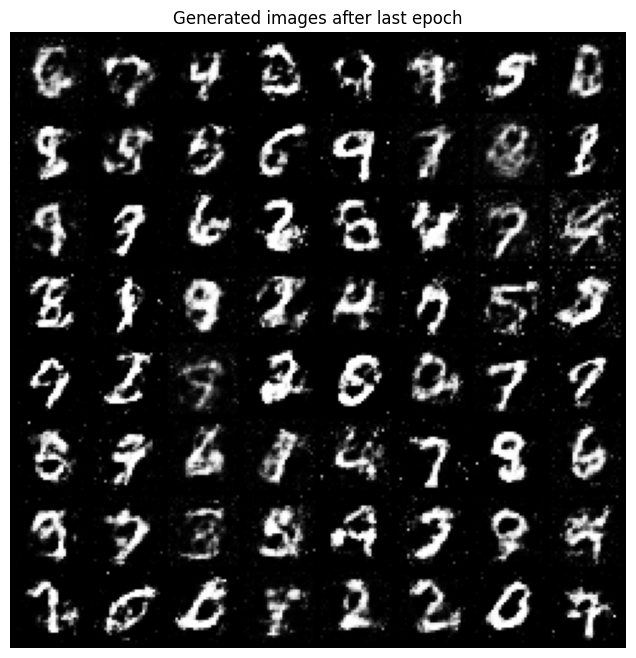

In [38]:
##########################
### VISUALIZATION
##########################

for i in range(0, NUM_EPOCHS, 5):

    plt.figure(figsize=(8, 8))
    plt.axis('off')
    plt.title(f'Generated images at epoch {i}')
    plt.imshow(np.transpose(log_dict['images_from_noise_per_epoch'][i], (1, 2, 0)))
    plt.show()


plt.figure(figsize=(8, 8))
plt.axis('off')
plt.title(f'Generated images after last epoch')
plt.imshow(np.transpose(log_dict['images_from_noise_per_epoch'][-1], (1, 2, 0)))
plt.show()